In [6]:
import pandas as pd
import numpy as np
import scanpy as sc
#import os
#import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scvi
#import gzip
from statsmodels.stats import weightstats as stests
from matplotlib import rcParams
mpl.rcParams['pdf.fonttype'] = 42

In [7]:
# Fisher’s exact (2-sided)
from scipy.stats import fisher_exact

In [ ]:
adata = scvi.data.read_h5ad("/Users/peien/NYU Langone Health Dropbox/Peien Jiang/evolution/PETRI_D2D4D23_250117/onlymRNA_scVI_JE2_D2D4D23_g20250117_seed12.h5ad")

/Users/peien/opt/anaconda3/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


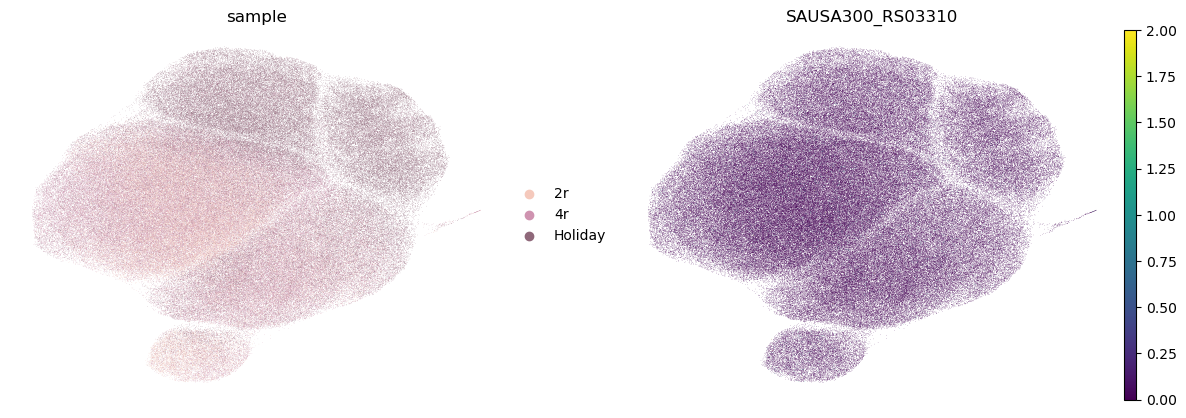

In [4]:
sc.pl.umap(
    adata,
    color=["sample","SAUSA300_RS03310"],
    frameon=False)

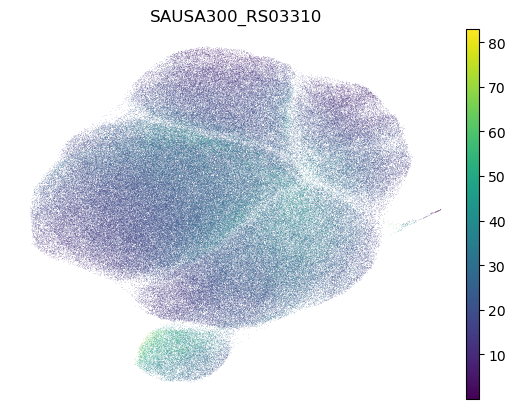

In [3]:
sc.pl.umap(
    adata,
    color=["SAUSA300_RS03310"],
    layer="scvi_normalized",
    frameon=False)

In [4]:
#Find all the cells that are expressing USA300_RS03310
adata_RS03310 = adata[adata[:, 'SAUSA300_RS03310'].X>0]
adata_RS03310

View of AnnData object with n_obs × n_vars = 3102 × 2507
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'sample', 'n_counts', '_scvi_batch', '_scvi_labels', 'leiden_scVI', 'leiden_scVI2', 'leiden_scVI_final', 'cluster_final'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts'
    uns: '_scvi', 'cluster_final_colors', 'leiden', 'leiden_scVI2_colors', 'leiden_scVI_colors', 'leiden_scVI_final_colors', 'neighbors', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_scVI', 'X_umap'
    layers: 'scvi_normalized'
    obsp: 'connectivities', 'distances'

In [5]:
pd.DataFrame(adata_RS03310.obs_names).to_csv("RS03310_D2D4D23_barcodes.csv", header=False, index=False)

## murG 1445029 C->A

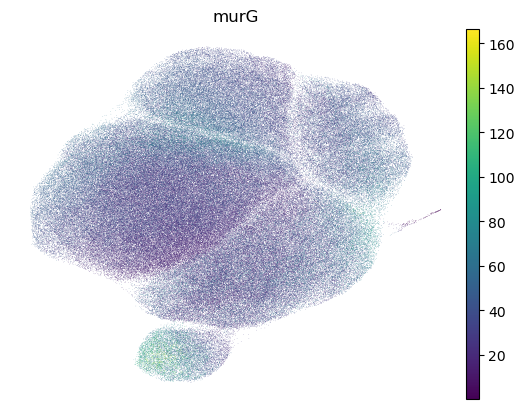

In [3]:
sc.pl.umap(
    adata,
    color=["murG"],
    layer="scvi_normalized",
    frameon=False)

In [4]:
#Find all the cells that are expressing USA300_RS03310
adata_murG = adata[adata[:, 'murG'].X>0]
adata_murG

View of AnnData object with n_obs × n_vars = 5037 × 2507
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'sample', 'n_counts', '_scvi_batch', '_scvi_labels', 'leiden_scVI', 'leiden_scVI2', 'leiden_scVI_final', 'cluster_final'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts'
    uns: '_scvi', 'cluster_final_colors', 'leiden', 'leiden_scVI2_colors', 'leiden_scVI_colors', 'leiden_scVI_final_colors', 'neighbors', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_scVI', 'X_umap'
    layers: 'scvi_normalized'
    obsp: 'connectivities', 'distances'

In [5]:
pd.DataFrame(adata_murG.obs_names).to_csv("murG_D2D4D23_barcodes.csv", header=False, index=False)

Then we used murG.sh to look the genetic base for the specific position in this gene

In [70]:
murG = pd.read_csv("murG_D2D4D23_1445029base.csv", header=0,
                  delimiter="\t",index_col=0)
murG

,G,A,T,C
Sample,,,,
BS28141A_bc1_10_bc2_11_bc3_88,0,0,0,0
BS28141A_bc1_10_bc2_17_bc3_25,0,0,0,0
BS28141A_bc1_10_bc2_42_bc3_50,0,0,0,0
BS28141A_bc1_10_bc2_48_bc3_34,0,0,0,0
BS28141A_bc1_10_bc2_65_bc3_52,0,0,0,0
...,...,...,...,...
BS28148A_bc1_96_bc2_17_bc3_60,0,0,0,0
BS28148A_bc1_96_bc2_50_bc3_24,0,0,0,0
BS28148A_bc1_9_bc2_22_bc3_66,0,0,0,0


In [71]:
murG.sum()

G     0
A    51
T     0
C    56
dtype: int64

In [72]:
murG.sum(axis=1).value_counts()

0    4930
1     107
dtype: int64

In [73]:
# 1) Keep only samples that exist in adata.obs_names (alignment safety)
murG_aligned = murG.loc[murG.index.intersection(adata.obs_names)]

# 2) For each row: pick the base with the largest value, but only if any value > 0
has_signal = (murG_aligned > 0).any(axis=1)
base_with_max = murG_aligned.idxmax(axis=1)     # returns the column (G/A/T/C) of the max
base_with_max[~has_signal] = np.nan            # rows with all zeros -> NaN (or set to 'none')

# 3) Assign into adata.obs['apt'], reindexed to all cells (samples) in adata
adata_murG.obs['1445029base'] = base_with_max.reindex(adata_murG.obs_names)
adata_murG.obs['1445029base'].value_counts()

/var/folders/51/n69nfv650kj287fzxg37b8r80000gn/T/ipykernel_2297/1951550827.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_murG.obs['1445029base'] = base_with_max.reindex(adata_murG.obs_names)


C    56
A    51
Name: 1445029base, dtype: int64

/Users/peien/opt/anaconda3/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
/Users/peien/opt/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/peien/opt/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/peien/opt/anaconda3/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


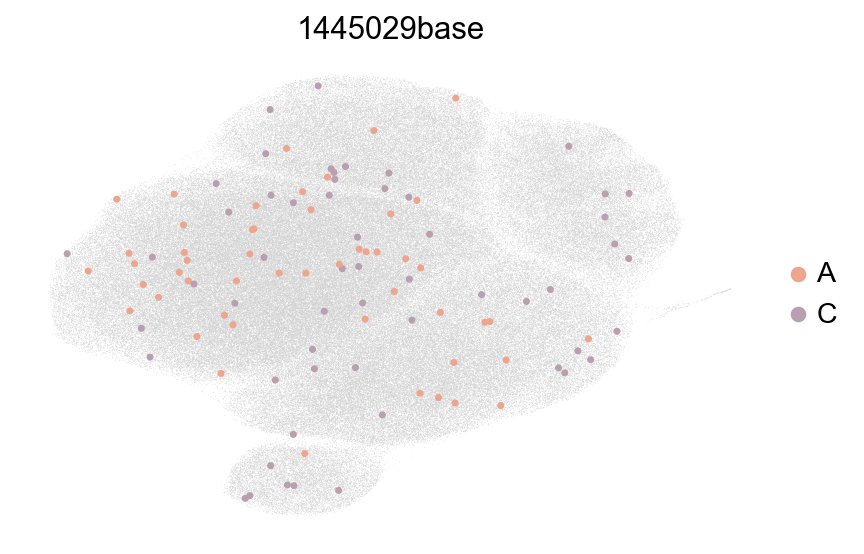

In [138]:
sc.set_figure_params(figsize=(6, 4))

# Create a new figure and axis
fig, ax = plt.subplots()

# First, plot the general UMAP without showing it (show=False)
sc.pl.umap(adata, show=False, ax=ax)

# Then, plot the UMAP for the subset of data with custom colors on the same axis
sc.pl.umap(adata_murG[adata_murG.obs['1445029base'].notna()],
           color="1445029base",
           palette=["#EEA58E",'#b99fb1'],  #A:"#EEA58E";C:"#D0D08A"; G:"#87C0D9"; T:'#C9BAD7'; 
           s=40,      
           alpha=1,  
           ax=ax,
           frameon=False,
          save="murG1445029base.pdf")

In [129]:
# 1) Build the contingency table
adata_murG.obs['cluster'] = adata_murG.obs['cluster_final'].astype('string').str[0]
df = adata_murG.obs[['1445029base', 'cluster']].copy()
df = df.dropna(subset=['1445029base', 'cluster'])
df = df[df['1445029base'].isin(['A', 'C', 'G', 'T'])]  # keep only canonical bases
ct = pd.crosstab(df['cluster'], df['1445029base']) 
ct

1445029base,A,C
cluster,,
L,40,30
M,10,20
S,1,6


In [130]:
oddsratio, p_fisher = fisher_exact(ct.drop(index=['S']), alternative='two-sided')
p_fisher 

0.04858163161294097

In [133]:
mapping = {
    'L': 'classical',
    'M': 'classical',
    'L_evolved': 'new',
    'M_evolved': 'new',
}

In [131]:
adata_murG.obs['state'] = pd.Series(adata_murG.obs['cluster_final']).astype('string').map(mapping)
df = adata_murG.obs[['1445029base', 'state']].copy()
df = df.dropna(subset=['1445029base', 'state'])
df = df[df['1445029base'].isin(['A', 'C', 'G', 'T'])]  # keep only canonical bases
ct = pd.crosstab(df['state'], df['1445029base']) 
ct

1445029base,A,C
state,,
classical,45,34
new,5,16


In [132]:
oddsratio, p_fisher = fisher_exact(ct, alternative='two-sided')
p_fisher 

0.012825176741999747

## citZ 1799669 G->A

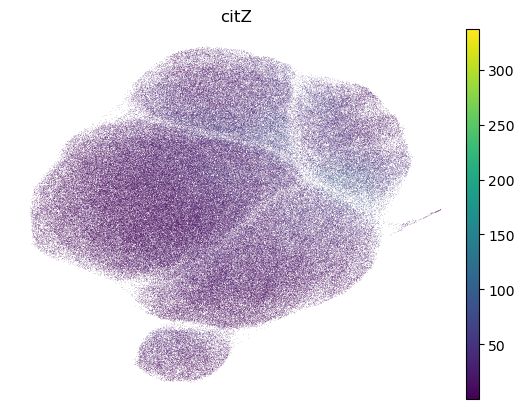

In [6]:
sc.pl.umap(
    adata,
    color=["citZ"],
    layer="scvi_normalized",
    frameon=False)

In [59]:
#Find all the cells that are expressing USA300_RS03310
adata_citZ = adata[adata[:, 'citZ'].X>0]
adata_citZ

View of AnnData object with n_obs × n_vars = 2563 × 2507
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'sample', 'n_counts', '_scvi_batch', '_scvi_labels', 'leiden_scVI', 'leiden_scVI2', 'leiden_scVI_final', 'cluster_final'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts'
    uns: '_scvi', 'cluster_final_colors', 'leiden', 'leiden_scVI2_colors', 'leiden_scVI_colors', 'leiden_scVI_final_colors', 'neighbors', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_scVI', 'X_umap'
    layers: 'scvi_normalized'
    obsp: 'connectivities', 'distances'

In [8]:
pd.DataFrame(adata_citZ.obs_names).to_csv("citZ_D2D4D23_barcodes.csv", header=False, index=False)

Then we used citZ.sh to look the genetic base for the specific position in this gene

In [60]:
citZ = pd.read_csv("citZ_D2D4D23_1799669base.csv", header=0,
                  delimiter="\t",index_col=0)
citZ

,G,A,T,C
Sample,,,,
BS28141A_bc1_10_bc2_28_bc3_36,0,0,0,0
BS28141A_bc1_11_bc2_19_bc3_86,0,0,0,0
BS28141A_bc1_11_bc2_27_bc3_1,0,0,0,0
BS28141A_bc1_11_bc2_53_bc3_54,0,0,0,0
BS28141A_bc1_11_bc2_70_bc3_55,0,0,0,0
...,...,...,...,...
BS28148A_bc1_96_bc2_65_bc3_91,0,0,0,0
BS28148A_bc1_96_bc2_83_bc3_91,0,0,0,0
BS28148A_bc1_96_bc2_96_bc3_81,0,0,0,0


In [61]:
citZ.sum()

G    85
A    23
T     0
C     1
dtype: int64

In [62]:
citZ.sum(axis=1).value_counts()

0    2454
1     109
dtype: int64

In [ ]:
# 1) Keep only samples that exist in adata.obs_names (alignment safety)
citZ_aligned = citZ.loc[citZ.index.intersection(adata.obs_names)]

# 2) For each row: pick the base with the largest value, but only if any value > 0
has_signal = (citZ_aligned > 0).any(axis=1)
base_with_max = citZ_aligned.idxmax(axis=1)     # returns the column (G/A/T/C) of the max
base_with_max[~has_signal] = np.nan            # rows with all zeros -> NaN (or set to 'none')

# 3) Assign into adata.obs['apt'], reindexed to all cells (samples) in adata
adata_citZ.obs['1799669base'] = base_with_max.reindex(adata_citZ.obs_names)
adata_citZ.obs['1799669base'].value_counts()

/var/folders/51/n69nfv650kj287fzxg37b8r80000gn/T/ipykernel_2297/4253037724.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_citZ.obs['1799669base'] = base_with_max.reindex(adata_citZ.obs_names)


G    85
A    23
C     1
Name: 1799669base, dtype: int64

/Users/peien/opt/anaconda3/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
/Users/peien/opt/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/peien/opt/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/peien/opt/anaconda3/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


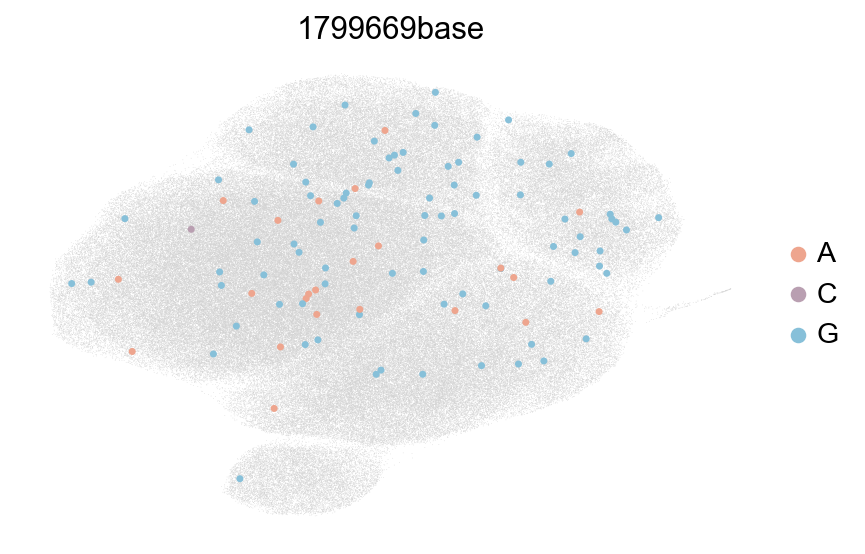

In [139]:
sc.set_figure_params(figsize=(6, 4))

# Create a new figure and axis
fig, ax = plt.subplots()

# First, plot the general UMAP without showing it (show=False)
sc.pl.umap(adata, show=False, ax=ax)

# Then, plot the UMAP for the subset of data with custom colors on the same axis
sc.pl.umap(adata_citZ[adata_citZ.obs['1799669base'].notna()],
           color="1799669base",
           palette=["#EEA58E","#b99fb1","#87C0D9"],   #A:'#D0D08A';C:"#C9BAD7"; G:"#87C0D9"; T:"#EEA58E";
           s=40,        
           ax=ax,
           frameon=False,
          save="citZ1799669base.pdf")

In [121]:
# 1) Build the contingency table
adata_citZ.obs['cluster'] = adata_citZ.obs['cluster_final'].astype('string').str[0]
df = adata_citZ.obs[['1799669base', 'cluster']].copy()
df = df.dropna(subset=['1799669base', 'cluster'])
df = df[df['1799669base'].isin(['A', 'C', 'G', 'T'])]  # keep only canonical bases
ct = pd.crosstab(df['cluster'], df['1799669base']) 
ct

1799669base,A,C,G
cluster,,,
L,16,1,54
M,7,0,30
S,0,0,1


In [125]:
ct.drop(columns=['C'],index=['S'])

1799669base,A,G
cluster,,
L,16,54
M,7,30


In [126]:
oddsratio, p_fisher = fisher_exact(ct.drop(columns=['C'],index=['S']), alternative='two-sided')
p_fisher 

0.8054165329308829

In [127]:
adata_citZ.obs['state'] = pd.Series(adata_citZ.obs['cluster_final']).astype('string').map(mapping)
df = adata_citZ.obs[['1799669base', 'state']].copy()
df = df.dropna(subset=['1799669base', 'state'])
df = df[df['1799669base'].isin(['A', 'C', 'G', 'T'])]  # keep only canonical bases
ct = pd.crosstab(df['state'], df['1799669base']) 
ct

1799669base,A,C,G
state,,,
classical,20,1,46
new,3,0,38


In [128]:
oddsratio, p_fisher = fisher_exact(ct.drop(columns=['C']), alternative='two-sided')
p_fisher 

0.006808675981025269

## apt, 1743889 G->T

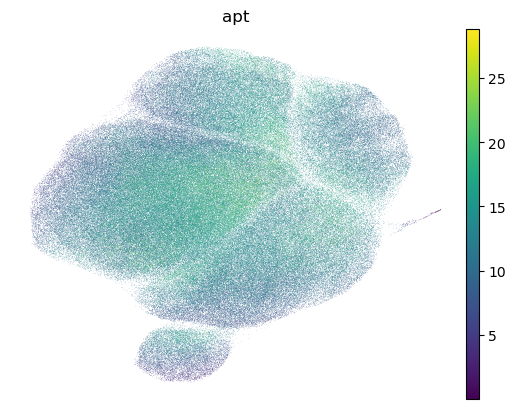

In [9]:
sc.pl.umap(
    adata,
    color=["apt"],
    layer="scvi_normalized",
    frameon=False)

In [11]:
#Find all the cells that are expressing USA300_RS03310
adata_apt = adata[adata[:, 'apt'].X>0]
adata_apt

View of AnnData object with n_obs × n_vars = 1894 × 2507
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'sample', 'n_counts', '_scvi_batch', '_scvi_labels', 'leiden_scVI', 'leiden_scVI2', 'leiden_scVI_final', 'cluster_final'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts'
    uns: '_scvi', 'cluster_final_colors', 'leiden', 'leiden_scVI2_colors', 'leiden_scVI_colors', 'leiden_scVI_final_colors', 'neighbors', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_scVI', 'X_umap'
    layers: 'scvi_normalized'
    obsp: 'connectivities', 'distances'

In [12]:
pd.DataFrame(adata_apt.obs_names).to_csv("apt_D2D4D23_barcodes.csv", header=False, index=False)

Then we used apt.sh to look the genetic base for the specific position in this gene

In [16]:
apt = pd.read_csv("apt_D2D4D23_1743889base.csv", header=0,
                  delimiter="\t",index_col=0)
apt

,G,A,T,C
Sample,,,,
BS28141A_bc1_10_bc2_40_bc3_49,0,0,0,0
BS28141A_bc1_10_bc2_49_bc3_71,0,0,0,0
BS28141A_bc1_10_bc2_49_bc3_8,0,0,0,0
BS28141A_bc1_10_bc2_68_bc3_46,0,0,0,0
BS28141A_bc1_10_bc2_8_bc3_39,0,0,0,0
...,...,...,...,...
BS28148A_bc1_95_bc2_84_bc3_71,0,0,0,0
BS28148A_bc1_96_bc2_48_bc3_29,0,0,0,0
BS28148A_bc1_96_bc2_80_bc3_35,0,0,0,0


In [17]:
apt.sum()

G    140
A      0
T     18
C      0
dtype: int64

In [20]:
apt.sum(axis=1).value_counts()

0    1738
1     154
2       2
dtype: int64

In [21]:
apt[apt.sum(axis=1)==2]

,G,A,T,C
Sample,,,,
BS28142A_bc1_3_bc2_2_bc3_19,2,0,0,0
BS28144A_bc1_8_bc2_90_bc3_1,2,0,0,0


In [28]:
# 1) Keep only samples that exist in adata.obs_names (alignment safety)
apt_aligned = apt.loc[apt.index.intersection(adata.obs_names)]

# 2) For each row: pick the base with the largest value, but only if any value > 0
has_signal = (apt_aligned > 0).any(axis=1)
base_with_max = apt_aligned.idxmax(axis=1)     # returns the column (G/A/T/C) of the max
base_with_max[~has_signal] = np.nan            # rows with all zeros -> NaN (or set to 'none')

# 3) Assign into adata.obs['apt'], reindexed to all cells (samples) in adata
adata_apt.obs['1743889base'] = base_with_max.reindex(adata_apt.obs_names)

In [29]:
adata_apt.obs['1743889base'].value_counts()

G    138
T     18
Name: 1743889base, dtype: int64

/Users/peien/opt/anaconda3/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
/Users/peien/opt/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/peien/opt/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/peien/opt/anaconda3/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


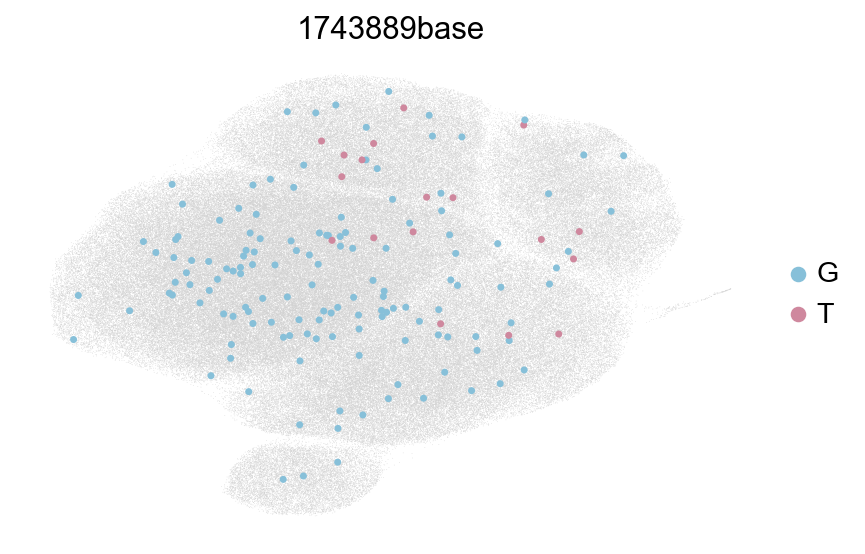

In [140]:
sc.set_figure_params(figsize=(6, 4))

# Create a new figure and axis
fig, ax = plt.subplots()

# First, plot the general UMAP without showing it (show=False)
sc.pl.umap(adata, show=False, ax=ax)

# Then, plot the UMAP for the subset of data with custom colors on the same axis
sc.pl.umap(adata_apt[adata_apt.obs['1743889base'].notna()],
           color="1743889base",
           palette=["#87C0D9","#cf889e" ],   #
           s=40,        
           ax=ax,
           frameon=False,
          save="apt1743889base.pdf")

In [104]:
# 1) Build the contingency table
adata_apt.obs['cluster'] = adata_apt.obs['cluster_final'].astype('string').str[0]
df = adata_apt.obs[['apt', 'cluster']].copy()
df = df.dropna(subset=['apt', 'cluster'])
df = df[df['apt'].isin(['A', 'C', 'G', 'T'])]  # keep only canonical bases
ct = pd.crosstab(df['cluster'], df['apt']) 
ct

apt,G,T
cluster,,
L,100,11
M,35,7
S,3,0


In [ ]:
# Fisher’s exact (2-sided)
from scipy.stats import fisher_exact
oddsratio, p_fisher = fisher_exact(ct.iloc[0:2,], alternative='two-sided')
p_fisher 

0.26703363990859574

In [117]:
mapping = {
    'L': 'classical',
    'M': 'classical',
    'L_evolved': 'new',
    'M_evolved': 'new',
}
s = pd.Series(adata.obs['cluster_final']).astype('string')
adata.obs['state'] = s.map(mapping)
adata.obs['state'].value_counts()

classical    206710
new           69717
Name: state, dtype: int64

In [118]:
# 1) Build the contingency table
adata_apt.obs['state'] = pd.Series(adata_apt.obs['cluster_final']).astype('string').map(mapping)
df = adata_apt.obs[['apt', 'state']].copy()
df = df.dropna(subset=['apt', 'state'])
df = df[df['apt'].isin(['A', 'C', 'G', 'T'])]  # keep only canonical bases
ct = pd.crosstab(df['state'], df['apt']) 
ct

apt,G,T
state,,
classical,115,6
new,20,12


In [119]:
oddsratio, p_fisher = fisher_exact(ct, alternative='two-sided')
p_fisher 

8.079124362921703e-06

## SAUSA300_RS03310, 689075

We used RS03310_D2D4D23.sh to look the genetic base for the specific position in this gene

In [9]:
RS03310 = pd.read_csv("RS03310_D2D4D23_689075base.csv", header=0,
                  delimiter="\t",index_col=0)
RS03310

,G,A,T,C
Sample,,,,
BS28141A_bc1_10_bc2_21_bc3_78,0,0,0,0
BS28141A_bc1_10_bc2_34_bc3_54,0,0,0,0
BS28141A_bc1_10_bc2_40_bc3_49,0,0,0,0
BS28141A_bc1_10_bc2_43_bc3_14,0,0,0,0
BS28141A_bc1_10_bc2_43_bc3_27,0,0,0,0
...,...,...,...,...
BS28148A_bc1_96_bc2_75_bc3_14,0,0,0,0
BS28148A_bc1_96_bc2_85_bc3_73,0,0,0,0
BS28148A_bc1_96_bc2_95_bc3_77,0,0,0,0


In [10]:
RS03310.sum()

G    38
A     0
T    35
C     0
dtype: int64

In [11]:
RS03310.sum(axis=1).value_counts()

0    3030
1      71
2       1
dtype: int64

In [12]:
RS03310[RS03310.sum(axis=1)==2]

,G,A,T,C
Sample,,,,
BS28144A_bc1_15_bc2_19_bc3_5,2,0,0,0


In [13]:
# 1) Keep only samples that exist in adata.obs_names (alignment safety)
RS03310_aligned = RS03310.loc[RS03310.index.intersection(adata.obs_names)]

# 2) For each row: pick the base with the largest value, but only if any value > 0
has_signal = (RS03310_aligned > 0).any(axis=1)
base_with_max = RS03310_aligned.idxmax(axis=1)     # returns the column (G/A/T/C) of the max
base_with_max[~has_signal] = np.nan            # rows with all zeros -> NaN (or set to 'none')

# 3) Assign into adata.obs['apt'], reindexed to all cells (samples) in adata
adata_RS03310.obs['689075base'] = base_with_max.reindex(adata_RS03310.obs_names)

/var/folders/51/n69nfv650kj287fzxg37b8r80000gn/T/ipykernel_18686/2592725780.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_RS03310.obs['689075base'] = base_with_max.reindex(adata_RS03310.obs_names)


In [14]:
adata_RS03310.obs['689075base'].value_counts()

G    37
T    35
Name: 689075base, dtype: int64

/Users/peien/opt/anaconda3/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
/Users/peien/opt/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/peien/opt/anaconda3/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


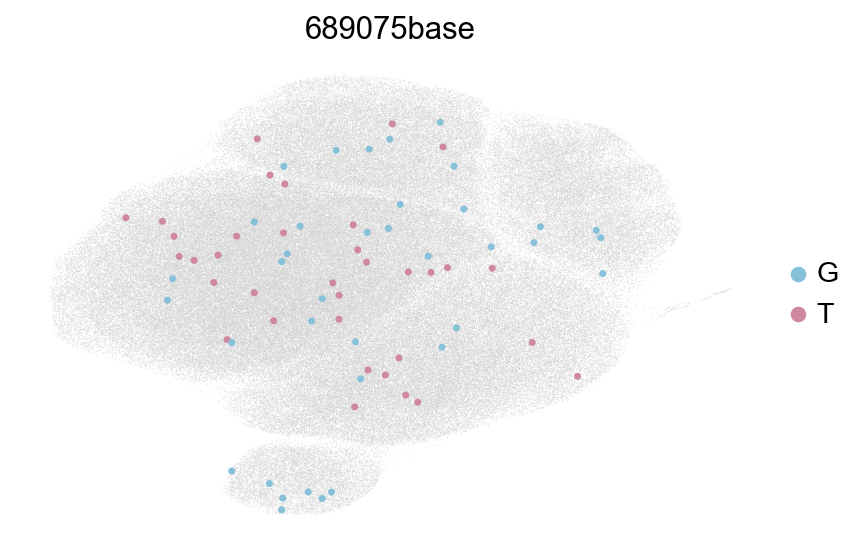

In [15]:
sc.set_figure_params(figsize=(6, 4))

# Create a new figure and axis
fig, ax = plt.subplots()

# First, plot the general UMAP without showing it (show=False)
sc.pl.umap(adata, show=False, ax=ax)

# Then, plot the UMAP for the subset of data with custom colors on the same axis
sc.pl.umap(adata_RS03310[adata_RS03310.obs['689075base'].notna()],
           color="689075base",
           palette=["#87C0D9","#cf889e" ],   #
           s=40,        
           ax=ax,
           frameon=False,
          save="RS03310_689075base.pdf")

In [20]:
# 1) Build the contingency table
adata_RS03310.obs['cluster'] = adata_RS03310.obs['cluster_final'].astype('string').str[0]
df = adata_RS03310.obs[['689075base', 'cluster']].copy()
df = df.dropna(subset=['689075base', 'cluster'])
df = df[df['689075base'].isin(['A', 'C', 'G', 'T'])]  # keep only canonical bases
ct = pd.crosstab(df['cluster'], df['689075base']) 
ct

689075base,G,T
cluster,,
L,22,26
M,8,9
S,7,0


In [21]:
# Fisher’s exact (2-sided)
from scipy.stats import fisher_exact
oddsratio, p_fisher = fisher_exact(ct.iloc[0:2,], alternative='two-sided')
p_fisher 

1.0

In [22]:
mapping = {
    'L': 'classical',
    'M': 'classical',
    'L_evolved': 'new',
    'M_evolved': 'new',
}
s = pd.Series(adata.obs['cluster_final']).astype('string')
adata.obs['state'] = s.map(mapping)
adata.obs['state'].value_counts()

classical    206710
new           69717
Name: state, dtype: int64

In [23]:
# 1) Build the contingency table
adata_RS03310.obs['state'] = pd.Series(adata_RS03310.obs['cluster_final']).astype('string').map(mapping)
df = adata_RS03310.obs[['689075base', 'state']].copy()
df = df.dropna(subset=['689075base', 'state'])
df = df[df['689075base'].isin(['A', 'C', 'G', 'T'])]  # keep only canonical bases
ct = pd.crosstab(df['state'], df['689075base']) 
ct

689075base,G,T
state,,
classical,18,31
new,12,4


In [24]:
oddsratio, p_fisher = fisher_exact(ct, alternative='two-sided')
p_fisher 

0.010053909295754308